In [1]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statistics import mean
import scipy
from pathlib import Path
import math
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import interp1d
from scipy.optimize import Bounds
from scipy.fft import fft, fftfreq
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal 
from scipy.signal import lombscargle
import operator

In [83]:
#Plotting Options
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.style.use('seaborn')

textwidth = 5.9

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times New Roman"

In [176]:
#choose filepath to desired data
path = '/Volumes/KESU/may19/polarized/'

# Import Calibration Data

Import hdf5 data generated from calculate_POL 

In [178]:
with h5py.File(path+ 'poldata.h5', "r") as file:
    var = file['/var'][()]
    #var1 = file['/var1'][()]
    #var2 = file['/var2'][()]
    
    waves = file['/waves'][()]
    angles = file['/angles'][()]
    #nedt =  file['/nedt'][()]
    
    R1 = file['/responses1'][()]
    R2 = file['/responses2'][()]
    #E1 = file['/responses_err1'][()]
    #E2 = file['/responses_err2'][()]


# Instrument Model

## Instrument design parameters

In [179]:
cdse_thickness = 5.01
lambda_min = 7;
lambda_max = 12;

## Retardance Model

Import refractive index data to build expected retardance arrays

In [6]:
no = pd.read_csv("/Users/kirahart/Dropbox/Dissertation/theory/Lisitsa-o.csv")
ne = pd.read_csv("/Users/kirahart/Dropbox/Dissertation/theory/Lisitsa-e.csv")

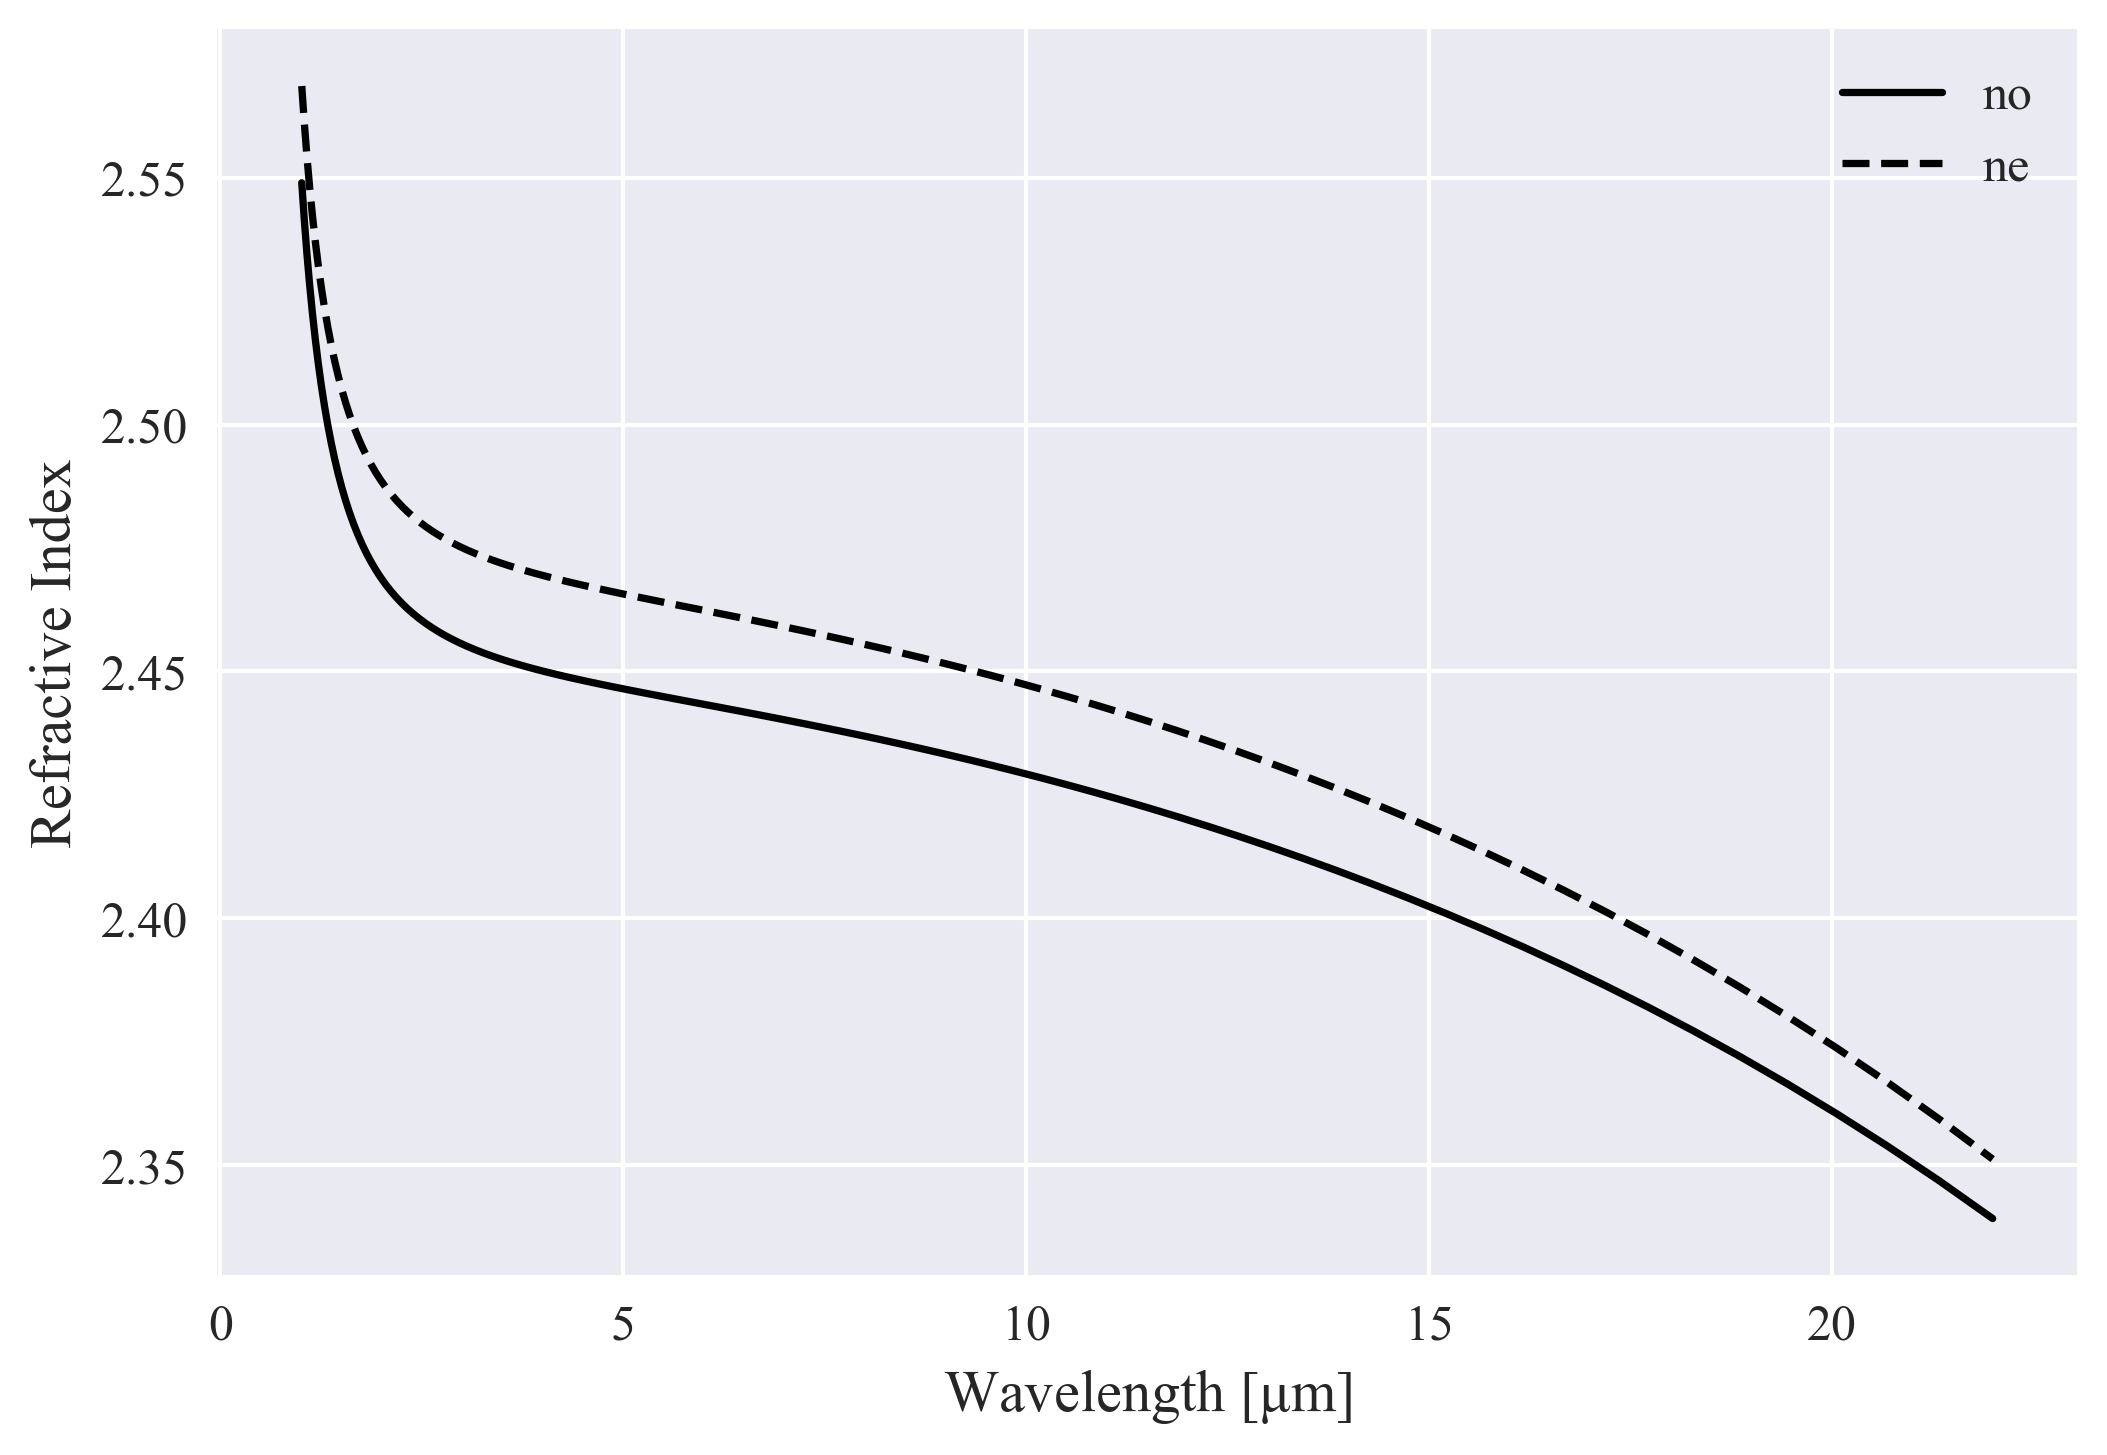

In [7]:
plt.plot(no['wl'],no['n'],'k',label = 'no')
plt.plot(ne['wl'],ne['n'],'k--',label = 'ne')
plt.ylabel("Refractive Index")
plt.xlabel('Wavelength [$\mathdefault{\mu}$m]')
plt.legend()
plt.gcf().set_dpi(300)
plt.show()

In [8]:
delta_n = ne['n']-no['n']

In [9]:
birefringence = interp1d(no['wl'], delta_n, kind='cubic')


In [10]:
def retardance(wavelength):
    d = float(birefringence(wavelength))
    return(cdse_thickness*d*1000)

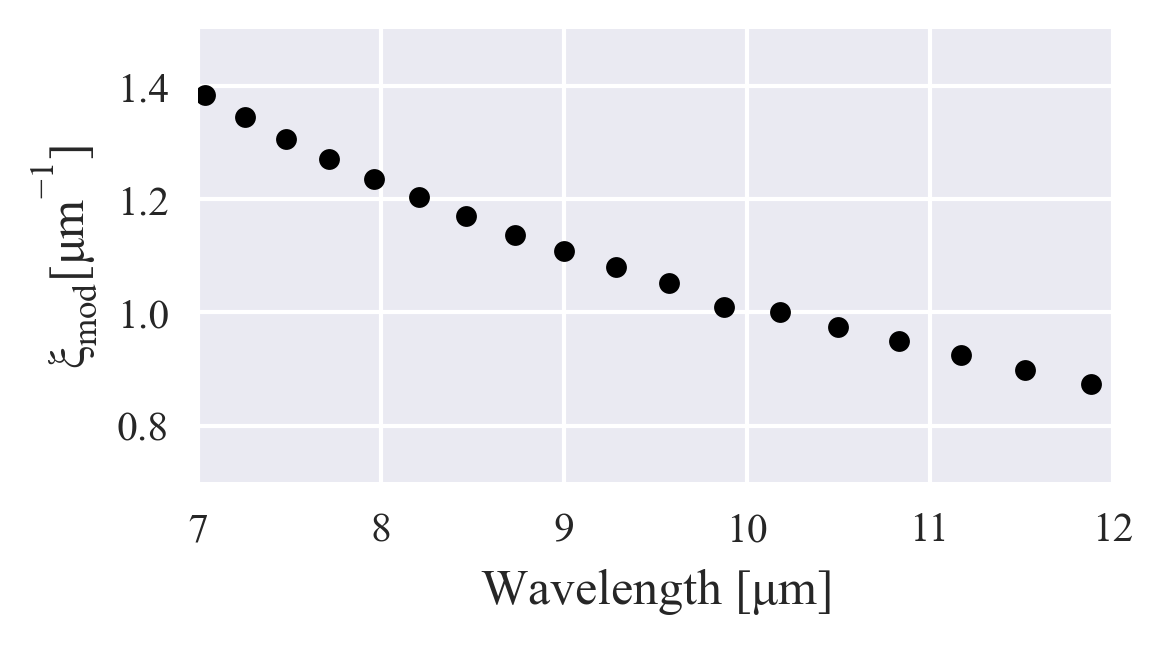

In [180]:
ret = list(map(lambda x: (retardance(x)/x)%2*np.pi, no['wl']))

ret = -np.diff(ret)
for r in range(len(ret)-1):
    v = ret[r]
    if np.abs(v) > 2:
        vnew = (ret[r-1]+ret[r+1])/2
        ret[r] =vnew

fig = plt.subplots(figsize = [textwidth/1.5,2])
plt.plot(no['wl'][:-1],ret,'k.',markersize = 10)
plt.ylabel("$\mathdefault{\\xi_{mod}   [\mu m^{-1}]}$")
plt.xlabel('Wavelength [$\mathdefault{\mu}$m]')
plt.xlim(7,12)
plt.ylim(.7,1.5)
plt.gcf().set_dpi(300)
plt.show()

## Determine Spectral Windows 

$\Delta\lambda$ is the maximum size of the window that can be used to demodulate as a function of center wavelength $\lambda_c$

In [181]:
def delta_lambda(lambda_c):
    delta = retardance(lambda_c)
    return(lambda_c**2/(delta*(1 +(lambda_c**2 / (4*delta**2)))))

def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

Now, determine the spectral windows for demodulaation, returning the wavelength windows and the pixel numbers

In [182]:
lambda_c = []
lambda1  = []
lambda2  = []
pixel_c = []
pixel1  = []
pixel2  = [] 
for l in waves:
    size = delta_lambda(l)
    low  = l-size/2
    high = l+size/2
    if low > lambda_min and high < lambda_max:
        lambda_c.append(l)
        lambda1.append(low)
        lambda2.append(high)
        
        pixel_c.append(find_nearest(waves,l))
        pixel1.append(find_nearest(waves,low))
        pixel2.append(find_nearest(waves,high))

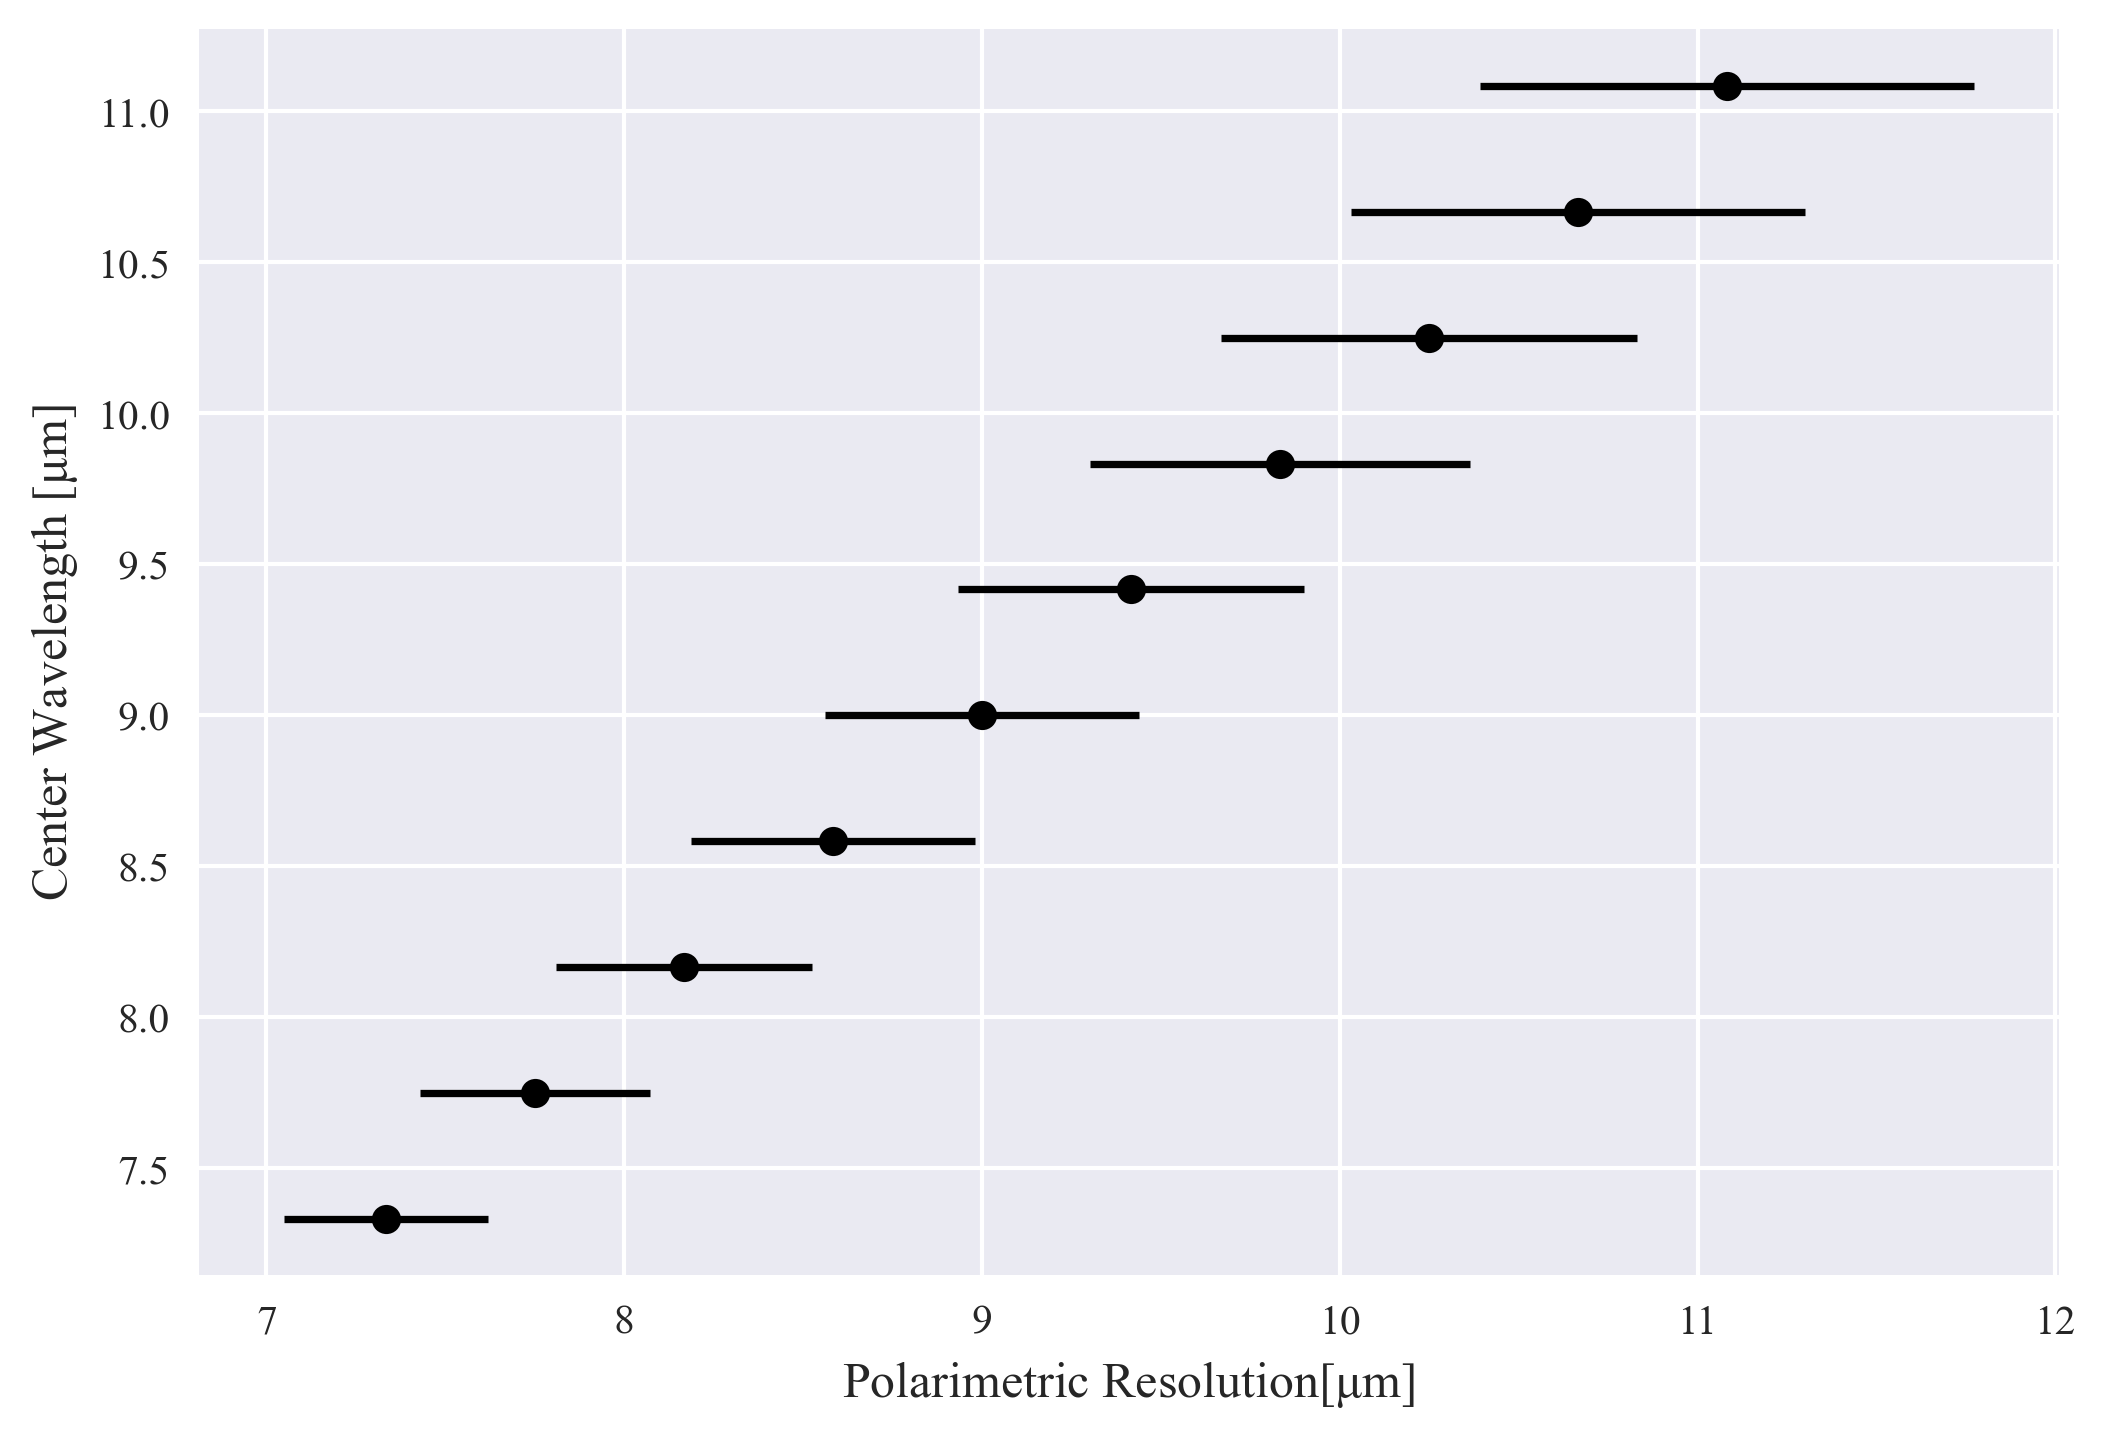

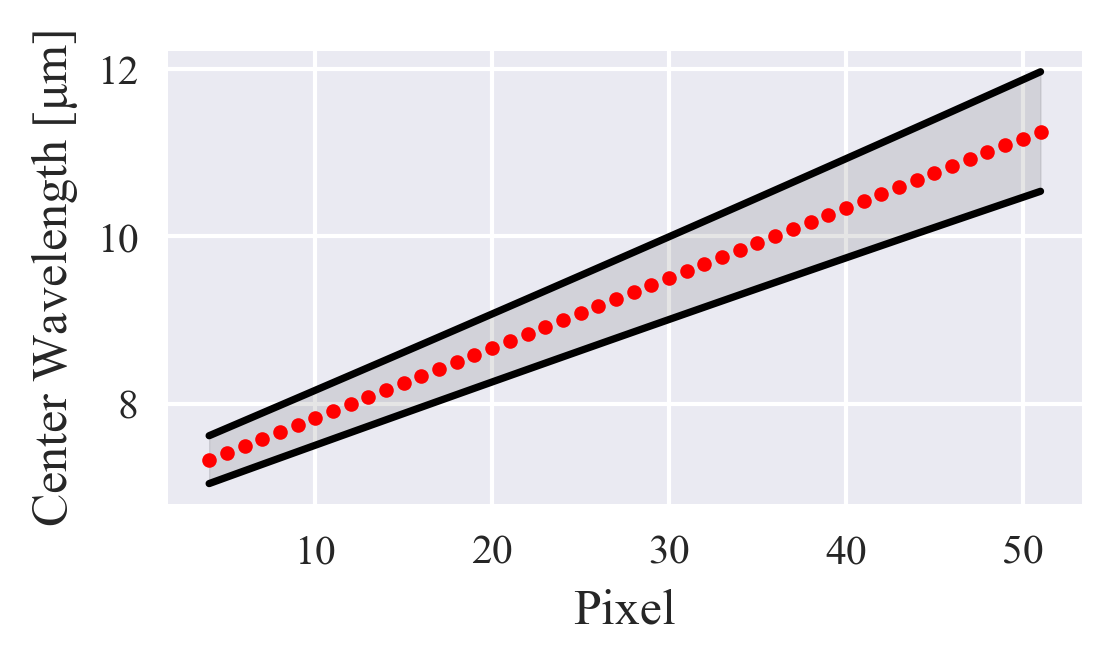

In [183]:
f, (ax1) = plt.subplots()

ax1.errorbar(lambda_c[::5],lambda_c[::5],xerr = (np.array(lambda1)- np.array(lambda2))[::5]/2,fmt = 'ko')
plt.grid(True) 
plt.xlabel("Polarimetric Resolution[$\mathdefault{\mu}$m]")
plt.ylabel("Center Wavelength [$\mathdefault{\mu}$m]")
plt.gcf().set_dpi(300)
plt.show()

fig = plt.subplots(figsize = [textwidth/1.5,2])
plt.plot(pixel_c,lambda_c,'.r')
plt.plot(pixel_c,lambda1,'k-')
plt.plot(pixel_c,lambda2,'k-')
plt.fill_between(pixel_c,lambda1,lambda2,color = 'k',alpha = .1)
plt.xlabel("Pixel")
plt.ylabel("Center Wavelength [$\mathdefault{\mu}$m]")
plt.gcf().set_dpi(300)
plt.show()

## Calculate the carrier frequency expected in each window

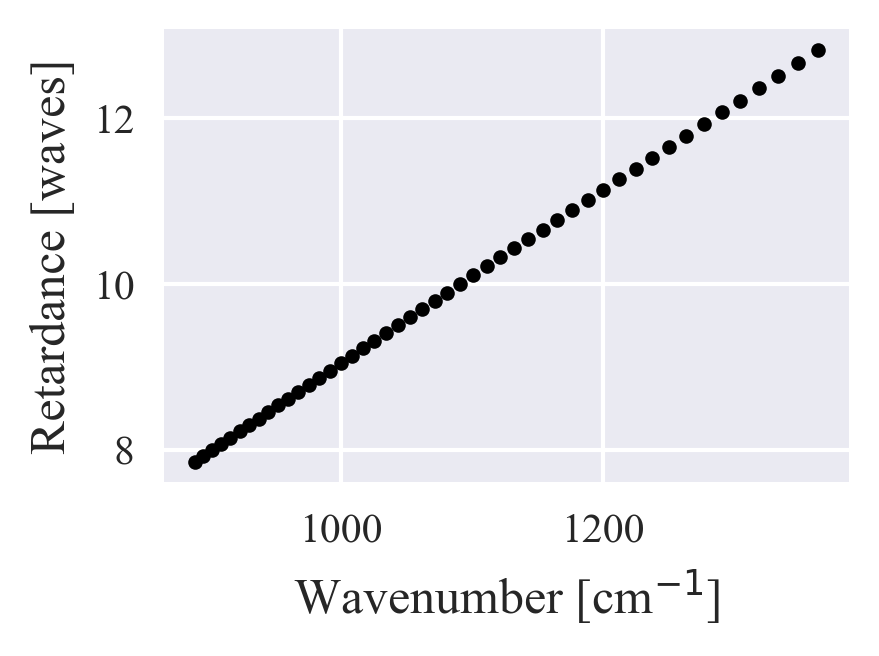

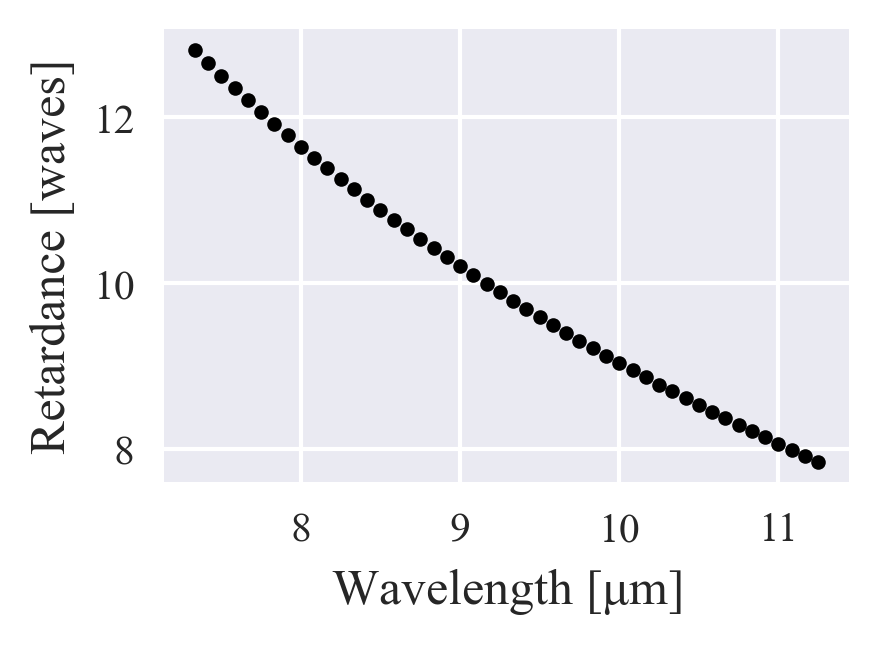

In [184]:

fig = plt.subplots(figsize = [textwidth/2,2])
freqs = list(map(lambda x: retardance(x)/x, lambda_c))
wavenums = np.divide(1,lambda_c)
freqs1 = list(map(lambda x: retardance(x)/x, lambda1))
freqs2 = list(map(lambda x: retardance(x)/x, lambda2))
plt.plot(np.divide(1,np.multiply(lambda_c,1e-4)),freqs,'k.')
plt.ylabel('Retardance [waves]')
plt.xlabel('Wavenumber [cm$^{-1}$]')
plt.gcf().set_dpi(300)
plt.show()

fig = plt.subplots(figsize = [textwidth/2,2])
plt.plot(lambda_c,freqs,'k.')
plt.ylabel('Retardance [waves]')
plt.xlabel('Wavelength [$\mathdefault{\mu}$m]')
plt.gcf().set_dpi(300)
plt.show()

## Model System Functions

In [185]:
def M(lambda_c,DOLP,AOLP,W,delta_error,offset):
    delta = 2*math.pi * retardance(lambda_c) /lambda_c
    return(DOLP*W*np.cos(delta*delta_error +offset+2*AOLP))

#The Demodulation Kernals 
def F(lambda_c,delta_error,offset):
    delta = 2*math.pi * retardance(lambda_c) /lambda_c
    return(np.cos(delta*delta_error +offset))

def G(lambda_c,delta_error,offset):
    delta = 2*math.pi * retardance(lambda_c) /lambda_c
    return(np.sin(delta*delta_error +offset))

#definition of modulation in terms of u adn q
def Mqu(lambda_c,Q,U,Wq,Wu,F,G):
    delta = 2*math.pi * retardance(lambda_c) /lambda_c
    return(Q*Wq*F-U*Wu*G)

In [186]:
def M_array(waves,DOLP,AOLP,W,delta_error,offset):
    mod = np.zeros(len(waves))
    for i in range(len(waves)):
        m = M(waves[i],DOLP,AOLP,W,delta_error,offset)
        mod[i] = m
    return(mod)

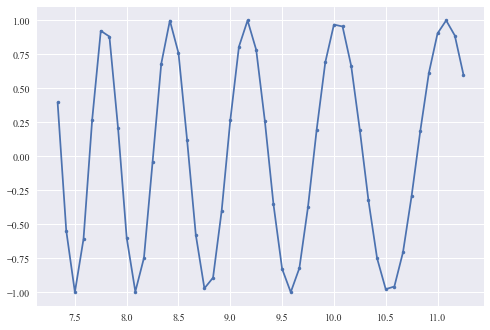

In [187]:
plt.plot(lambda_c,M_array(lambda_c,1,0,1,1,0),'.-')
plt.show()

#  Polarized Calibration

## Unpolarized Transmission

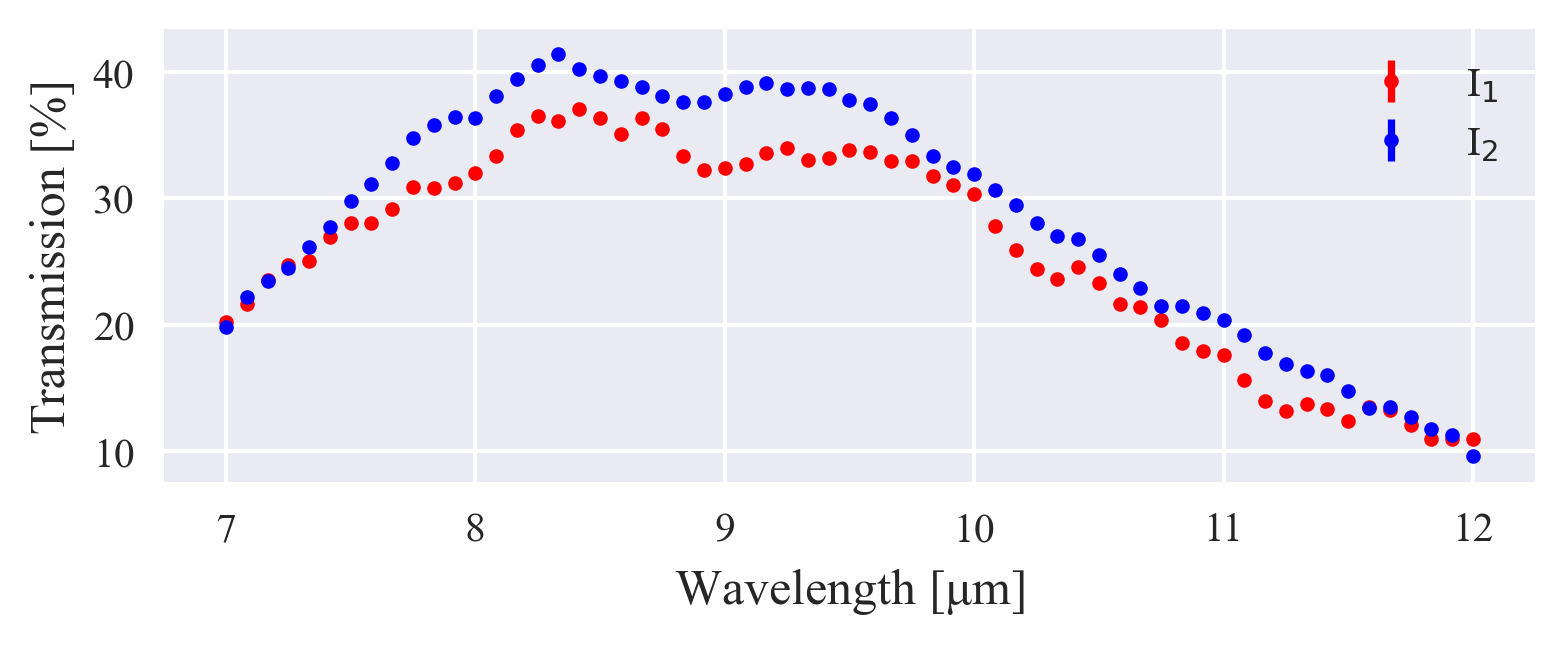

In [190]:
fig = plt.subplots(figsize = [textwidth,2])
plt.errorbar(waves,np.mean(R1,axis = 0)/(2*3.6) , yerr = np.std(R1,axis = 0)/np.mean(R1,axis = 0), fmt = '.r',label = 'I$_1$')
plt.errorbar(waves,np.mean(R2,axis = 0)/(2*3.6), yerr = np.std(R2,axis = 0)/np.mean(R2,axis = 0), fmt = '.b',label = 'I$_{2}$' )
plt.legend()
plt.gcf().set_dpi(300)
plt.ylabel('Transmission [%]')
plt.xlabel('Wavelength [$\mathdefault{\mu}$m]')
plt.show()



## Calculate AOLP dependent transmission

This function will correct for differences in transmission over a single period

In [191]:
def transmission_correction(I1,I2,iterations):
    T = 1
    i = 0
    while i < iterations:
        t = np.mean(I1)/np.mean(I2)
        T_update = T*t
        I2_update = t*I2
        I2 = I2_update
        T= T_update
        i = i+1;
    return(T)

In [192]:
transmission_aolp = np.zeros([len(angles),len(pixel_c)])
for a in range(len(angles)):
    I1 = R1[a]
    I2 = R2[a]*t_unpol
    for i in range(len(pixel_c)):
        v = transmission_correction(I1[pixel1[i]:pixel2[i]],I2[pixel1[i]:pixel2[i]],3)
        transmission_aolp[a,i] = v

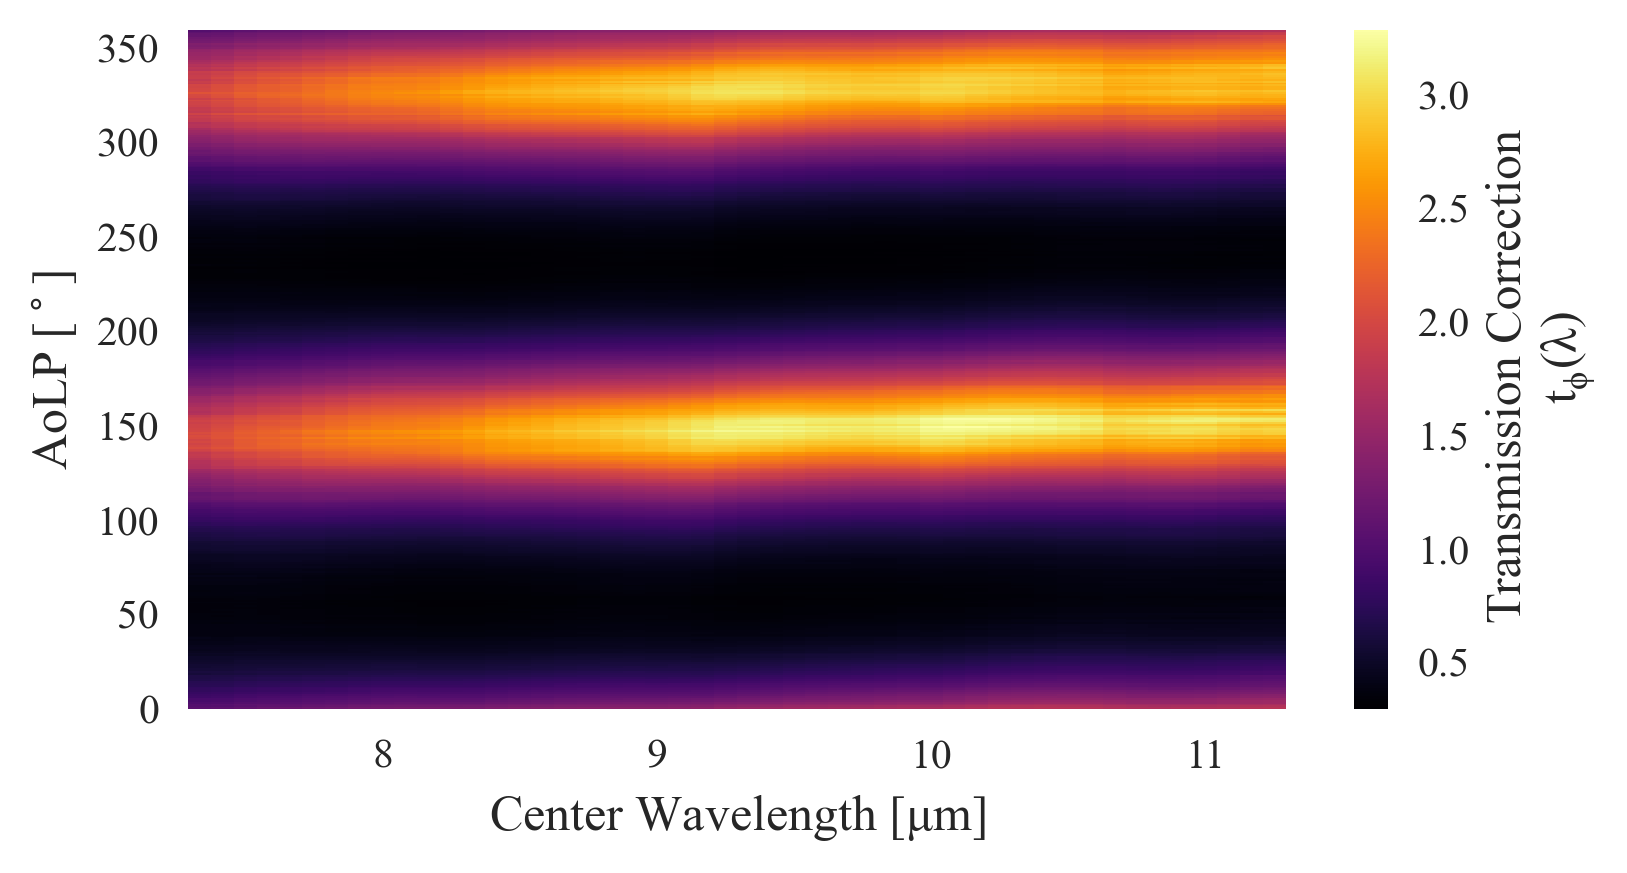

In [193]:
fig = plt.subplots(figsize = [textwidth,3])
plt.pcolormesh(lambda_c,angles,transmission_aolp,shading='auto',cmap = 'inferno')
plt.colorbar(label = "Transmission Correction \n  $\mathdefault{t_\phi (\lambda)}$")
plt.xlabel('Center Wavelength [$\mathdefault{\mu}$m]')
plt.ylabel('AoLP [$^\circ$]')
plt.gcf().set_dpi(300)
plt.show()

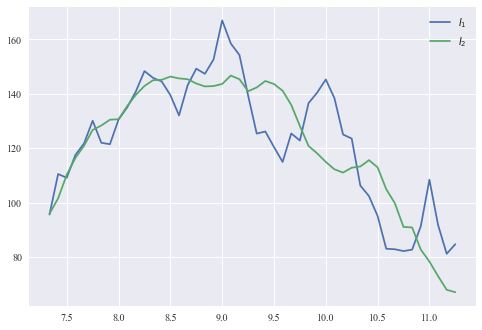

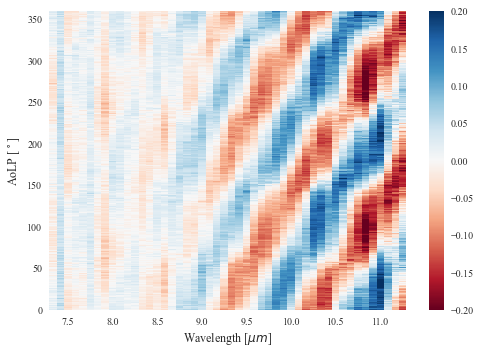

In [194]:
from scipy.optimize import leastsq

#calculate modulation function for calibration data
calibration_mod = np.zeros([len(angles),len(pixel_c)])
calibration_I1  = np.zeros([len(angles),len(pixel_c)])
calibration_I2  = np.zeros([len(angles),len(pixel_c)])

for a in range(len(angles)):
    I1 = R1[a,pixel_c[0]:pixel_c[-1]+1]/t_unpol[pixel_c[0]:pixel_c[-1]+1]
    I2 = R2[a,pixel_c[0]:pixel_c[-1]+1]*transmission_aolp[a]

    mod_a = (I1-I2)/(I1+I2)
                            
    calibration_I1[a]  = I1
    calibration_I2[a]  = I2
    calibration_mod[a] = mod_a

plt.errorbar(lambda_c,calibration_I1[50] ,label = '$I_1$')
plt.errorbar(lambda_c,calibration_I2[50] ,label = '$I_2$' )
plt.legend()
plt.show()

plt.pcolormesh(lambda_c,angles,calibration_mod,shading='auto',vmin = -.2,vmax = .2,cmap = 'RdBu')
plt.colorbar()
plt.xlabel('Wavelength [$\mu m$]')
plt.ylabel('AoLP [$^\circ$]')
plt.show()

## AoLP Calibration Fit

Here is an example of how W is determined based on wavelength

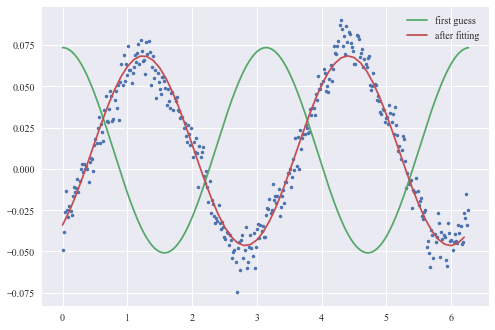

In [195]:
i = 22;
wavelength = lambda_c[i]

data = calibration_mod[:,i] #calibration data for wavelength lambda_c[i]
t = angles*np.pi/180

guess_mean = np.mean(data)
guess_std = 3*np.std(data)/(2**0.5)/(2**0.5)
guess_phase = 0
guess_freq = 2
guess_amp = 1

# we'll use this to plot our first estimate
data_first_guess = guess_std*np.cos(2*t+guess_phase) + guess_mean

# Define the function to optimize, in this case, we want to minimize the difference
# between the actual data and our "guessed" parameters
optimize_func = lambda x: x[0]*np.cos(x[1]*t+x[2]) + x[3] - data
est_W, est_freq, est_delta, est_offset = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]

# recreate the fitted curve using the optimized parameters
data_fit = est_W*np.cos(est_freq*t+est_delta) + est_offset

# recreate the fitted curve using the optimized parameters

fine_t = np.arange(0,max(t),0.1)
data_fit=est_W*np.cos(est_freq*fine_t+est_delta)+est_offset

plt.plot(t, data, '.')
plt.plot(t, data_first_guess, label='first guess')
plt.plot(fine_t, data_fit, label='after fitting')
plt.legend()
plt.show()

The function and applied to calibration data

In [212]:
def fit_mod_aolp(data,angles):
    t = angles*np.pi/180

    guess_mean = np.mean(data)
    guess_std = 3*np.std(data)/(2**0.5)/(2**0.5)
    guess_phase = 0
    guess_freq = 2
    guess_amp = 1

    optimize_func = lambda x: x[0]*np.cos(2*t+x[1]) - data
    est_W, est_delta, est_offset = leastsq(optimize_func, [guess_amp, guess_phase, guess_mean])[0]
    
    return(est_W, est_delta, est_offset)


In [213]:
W_est      = np.zeros(len(lambda_c))
delta_est  = np.zeros(len(lambda_c))
offset_est =  np.zeros(len(lambda_c))

for i in range(len(lambda_c)):
    (W_est[i],delta_est[i],offset_est[i])=fit_mod_aolp(calibration_mod[:,i],angles)

Text(0.5, 0.98, 'AoLP Fit Parameters')

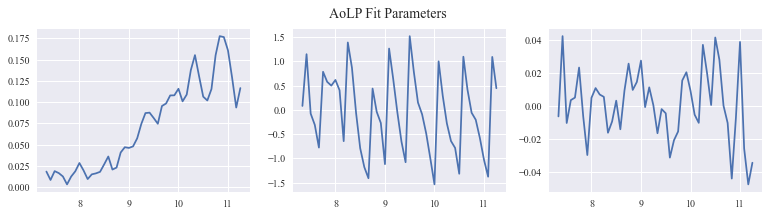

In [214]:
fig, axs = plt.subplots(1, 3, figsize=(13, 3))
axs[0].plot(lambda_c, np.abs(W_est))
axs[1].plot(lambda_c, delta_est)
axs[2].plot(lambda_c, offset_est)
fig.suptitle('AoLP Fit Parameters')

## Reconstructions

In [216]:
delta_error=1
offset= 0
Fs = list(map(lambda x: F(x,delta_error,offset), lambda_c))
Gs = list(map(lambda x: G(x,delta_error,offset), lambda_c))
Ms = list(map(lambda x: M(x,1,0,1,delta_error,offset), lambda_c))

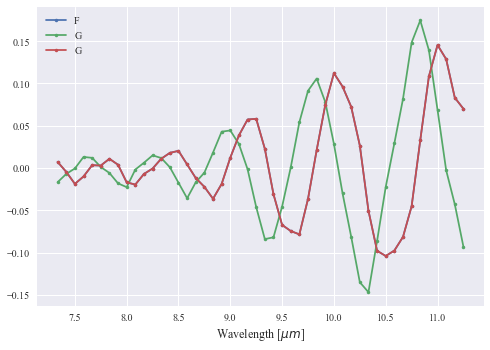

In [217]:
a=45;
data = calibration_mod[a]
q = np.cos(2*np.pi*angles[a]/180)
u = np.sin(2*np.pi*angles[a]/180)

plt.plot(lambda_c,np.array(np.abs(W_est)*Fs),'.-',label = "F")
plt.plot(lambda_c,np.array(np.abs(W_est)*Gs),'.-',label = "G")
plt.plot(lambda_c,np.array(np.abs(W_est)*Ms),'.-',label = "G")
plt.xlabel("Wavelength [$\mu m$]")
plt.ylabel("")
plt.legend()
plt.grid(True)

In [218]:

dolps = np.zeros([len(angles),len(lambda_c)])
iss = np.zeros([len(angles),len(lambda_c)])
vss = np.zeros([len(angles),len(lambda_c)])

for i in range(len(angles)):
    for j in range(len(lambda_c)):
        start = pixel1[j]
        stop  = pixel2[j]
        
        data = calibration_mod[i,:]
        correlations = signal.correlate(data[start:stop],Ms[start:stop], mode="same")

        ind, vss[i,j] = max(enumerate(correlations), key=operator.itemgetter(1))
        
        #calculate cooresponding aolp
        pixels = np.linspace(0,np.pi,stop-start)
        aolp_est = pixels[ind] 
        iss[i,j] = aolp_est
        
        #calculate DoLP
        Mest = list(map(lambda x: M(x,1,aolp_est,1,delta_error,offset), lambda_c))
        dolp = np.mean(np.abs(Mest[start:stop]-data[start:stop]))
        dolps[i,j] = dolp

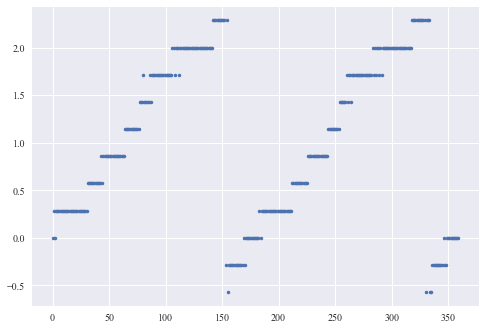

In [219]:
plt.plot(angles,iss[:,30]-iss[0,30],'.')

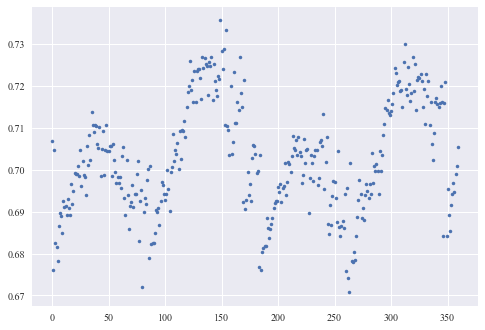

In [220]:
plt.plot(angles,dolps[:,30],'.')

# Demodulation in Fourier Space

## periodogram

In [166]:
from astropy.timeseries import LombScargle

-0.062109237788455854 0.07628951668937964
[[ 1.37982130e+02  1.33135584e+02  3.62489237e+01]
 [ 8.96429615e+01  6.59588518e+01  6.07065929e+01]
 [ 1.08789400e+02  3.79721069e+01  1.01947304e+02]
 [ 1.52291609e+02 -1.61270930e+01  1.51435303e+02]
 [ 6.71645247e+02 -3.57495134e+02  5.68598775e+02]
 [ 1.52566715e+03 -1.29131464e+03  8.12506459e+02]
 [ 4.37476440e+02 -4.34286744e+02  5.27319578e+01]
 [ 2.41082396e+02 -2.29367890e+02 -7.42367354e+01]
 [ 7.23694793e+01 -5.34383526e+01 -4.88025000e+01]
 [ 7.70382339e+01 -3.07266442e+01 -7.06453312e+01]
 [ 8.66417926e+01  3.22121411e-01 -8.66411938e+01]
 [ 5.70416310e+02  2.28093451e+02 -5.22827069e+02]
 [ 2.01776244e+02  1.46541193e+02 -1.38705917e+02]
 [ 2.15321027e+02  2.01328657e+02 -7.63538884e+01]]


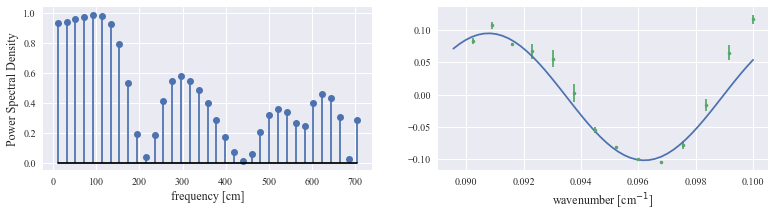

In [167]:
a = 1
j = 35
start = pixel1[j]
stop  = pixel2[j]
n = stop-start;

x = wavenums[start:stop]
data = (calibration_mod[a]+calibration_mod[a+180])/2
data_err = np.abs(calibration_mod[a]-calibration_mod[a+180])/10
y = data[start:stop]
dy = data_err[start:stop]

ls = LombScargle(x, y,dy)
frequency, power = ls.autopower(nyquist_factor= 1) #sampling in 1 period intervalsLombScargle(x, y,dy)

best_frequency = frequency[np.argmax(power)]
t_fit = np.linspace(wavenums[stop],wavenums[start])
y_fit = ls.model(t_fit, best_frequency)

[offset,u,q] = ls.model_parameters( best_frequency)
print(q,u)

X = ls.design_matrix(best_frequency)
print(X)

fig, axes = plt.subplots(1,2,figsize=(13, 3)); 
axes[0].stem(frequency, power,basefmt = 'k')
axes[0].set_xlabel('frequency [cm]')
axes[0].set_ylabel('Power Spectral Density')     

axes[1].plot(t_fit,y_fit)
axes[1].set_xlabel('wavenumber [cm$^{-1}$]')
axes[1].errorbar(x,y,yerr = dy,fmt='.')
plt.show()

In [168]:
def LombModel(j, data ,data_err):
    start = pixel1[j]
    stop  = pixel2[j]
    n = stop-start;

    x = wavenums[start:stop]
    y = data[start:stop]
    dy = data_err[start:stop]

    ls = LombScargle(x, y,dy)
    frequency, power = ls.autopower(nyquist_factor= 1) #sampling in 1 period intervalsLombScargle(x, y,dy)
    
    
    probability = [0.1, 0.05, 0.01]
    prob = ls.false_alarm_probability(power[5])  

    best_frequency = frequency[np.argmax(power)]
    if best_frequency < 0:
        [offset,u,q] = ls.model_parameters(-0.01)
    else:
        [offset,u,q] = ls.model_parameters(0.01)
    return([u,q,prob])

In [169]:
results = np.zeros([180,3])
j = 31
for a in range(180):
    data = (calibration_mod[a]+calibration_mod[a+180])/2
    data_err = np.abs(calibration_mod[a]-calibration_mod[a+180])/2
    
    results[a] = LombModel(j, data ,data_err)
    

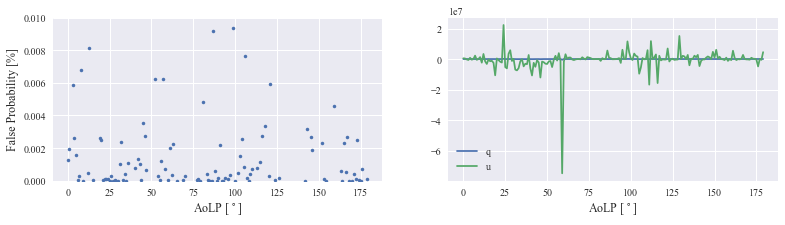

In [170]:
fig, axes = plt.subplots(1,2,figsize=(13, 3)); 
axes[0].plot(results[:,2]*100,'.')
axes[0].set_ylabel('False Probability [%]')   
axes[0].set_xlabel('AoLP [$^\circ$]')
axes[0].set_ylim([0,.01])

axes[1].plot(results[:,0], label = 'q')
axes[1].plot(results[:,1], label = 'u')
axes[1].legend()
axes[1].set_xlabel('AoLP [$^\circ$]')
plt.show()

In [171]:
def get_amp(samples):
    N = len(samples)
    x = np.linspace(-np.pi, np.pi, N, endpoint=False)
    template = np.exp(1j * x)
    corr = 2 / N * template@samples
    R = np.abs(corr)
    phi = np.log(corr).imag
    return R, phi